# Introduction

The goal of this project is to make an analysis of Kaggle's house price data(https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) and to try to compare it to Kyrgystan's

This kernel contains the following sections:

 1. Getting to know the data
 2. Selecting features
 3. Investigating the features correlation
 4. Creating a predictor
 5. Summary

## Import & set up

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams["figure.figsize"] = 20, 8

def plot_heatmap(data):
    sns.set(style = "white")
    corr = data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Take a brief look at the data

In [2]:
df = pd.read_csv('data/train.csv')
df.shape

(1460, 81)

In [3]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Missing data
We have to solve several answer on several questions here: 
 - Do we have NaN values?
 - Which features have the most NaN values?
 - How to deal with them?

In [4]:
total_count = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_count, percentage], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


As we can see the values of `PoolQC`, `MiscFeature`, `Alley`, `Fence` etc. have more than 15% of NaN values. Considering the fact that these values don't seem important we can make a conslusion that the best way to deal with these values is to drop them.

In [5]:
df = df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'])

The rest of the missing values we will handle differently by the type: numerical or categorical.

For numerical we will take the mean

In [6]:
numerical_features = df.select_dtypes(exclude = ['object']).columns
numerical_features.drop('SalePrice')
df[numerical_features].fillna(df.mean(), inplace=True)

For the sake of simplicity for the missing categorical values we will take the most popular type of them

In [7]:
categorical_features = df.select_dtypes(include = ["object"]).columns
for cat in categorical_features:
    df[cat].fillna(df[cat].value_counts().index[0], inplace=True)

Let's check if we have any NaN values left

In [8]:
df.isnull().sum().sort_values(ascending=False).head(10)

GarageYrBlt    81
MasVnrArea      8
ExterCond       0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
ExterQual       0
SalePrice       0
dtype: int64

Now let's select the features. Let's see the correlation for the `SalePrice`

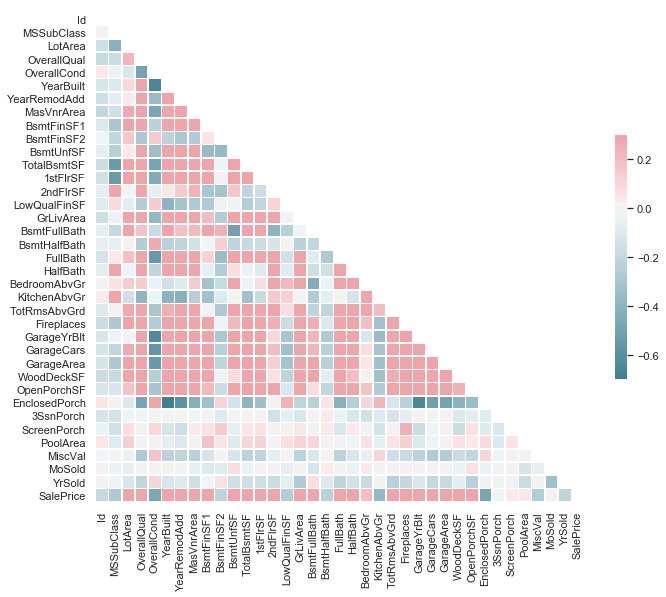

In [13]:
corr_matrix = df.corr()
plot_heatmap(corr_matrix)

In [14]:
corr_matrix.drop('SalePrice')['SalePrice'].sort_values(ascending=False).head(5)

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

For this project I'll use `OverallQual` and `GrLivArea` features.

## Features correlation analysis
First, let's see the distibution of the SalePrice

In [ ]:
sns.distplot(df['SalePrice'])

Based on the graph we can say that it has a normal distribution. Let's see the skewness and kurtosis

In [ ]:
df['SalePrice'].skew()

In [ ]:
df['SalePrice'].kurt()

Let's see the correlation between the target(`SalePrice`) and the chosen features(`OverallQual`, `GrLivArea`)

In [ ]:
sns.scatterplot(df['SalePrice'], df['GrLivArea'])

It seems that `GrLivArea` has a linear relation with `SalePrice`

In [ ]:
data = pd.concat([df['SalePrice'], df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

We can see that `OverallQual` also has a relation to the SalePrice

## Creating a prediction model
Now, let's try to make a simple Linear Regression model based on these two values

First, we need to define the predictors and the predictant and then divide the data into train and test parts

In [ ]:
X, y = df[['OverallQual', 'GrLivArea']], df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Now, let's fit a model and try to predict it

In [ ]:
reg = LinearRegression()
train_model = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

Let's see some estimation of it

In [ ]:
print("MAE: %f" % mean_absolute_error(y_test, y_pred))
print("R2: %f" % r2_score(y_test, y_pred))

## Conclusion
So, let's conclude what we did. In this kernel we first learned about the data, found out that some data is missing. So we had to deal with it. Next, we selected the features based on the correlation heatmap. We saw some visualisation of the correlation of these features to `SalePrice`. After that, we made a simple prediction model based on the selected features.  